This notebook contains experiments to find the most optimal k for kmeans

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..")) # adjust relative import as necessary
sys.path.append(PROJECT_ROOT)
from utils.data_processing import get_filtered_review_data, get_metadata

Load

In [2]:
metadata_df = get_metadata('Video_Games')
print(metadata_df.columns)

Loading metadata from data/Video_Games_metadata.pkl
Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'store', 'categories', 'details',
       'parent_asin'],
      dtype='object')


Prepare

In [3]:
# Make sure title/description are strings
metadata_df['title'] = metadata_df['title'].astype(str)
metadata_df['description'] = metadata_df['description'].astype(str)

# Combine them into one text column
metadata_df['combined_text'] = metadata_df['title'] + ' ' + metadata_df['description']

# drop any rows with completely empty text
metadata_df = metadata_df[metadata_df['combined_text'].str.strip().str.len() > 0]
metadata_df.reset_index(drop=True, inplace=True)

TF-IDF

In [4]:
vectorizer = TfidfVectorizer(
    stop_words='english',   # Remove English stop words
    max_features=5000,      # Limit to top 5k terms
)
X_tfidf = vectorizer.fit_transform(metadata_df['combined_text'])
print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (137266, 5000)


Finding best K. Plotting inertia and silhouette score

Fitting KMeans(k=8) on full data of shape (137266, 5000) ...
Fitting KMeans(k=9) on full data of shape (137266, 5000) ...
Fitting KMeans(k=10) on full data of shape (137266, 5000) ...
Fitting KMeans(k=11) on full data of shape (137266, 5000) ...
Fitting KMeans(k=12) on full data of shape (137266, 5000) ...
Fitting KMeans(k=13) on full data of shape (137266, 5000) ...


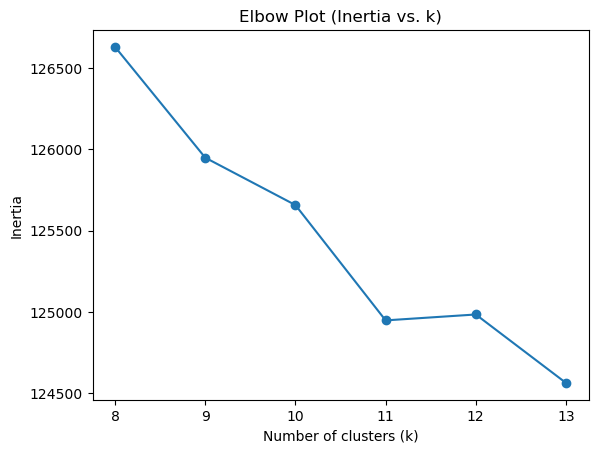

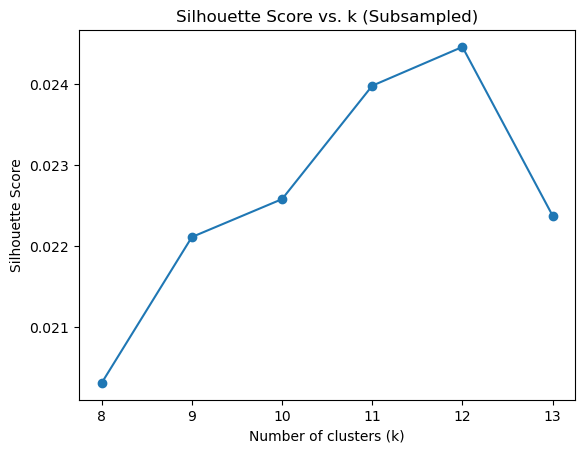

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random

# 1) Subsample to save time 
max_samples = 50000 
n_samples = X_tfidf.shape[0]
if n_samples > max_samples:
    subset_indices = random.sample(range(n_samples), max_samples)
    X_for_silhouette = X_tfidf[subset_indices]
else:
    X_for_silhouette = X_tfidf

# 2) Evaluate k in [8..13] 
ks = range(8, 14)
inertias = []
sil_scores = []

for k in ks:
    print(f"Fitting KMeans(k={k}) on full data of shape {X_tfidf.shape} ...")
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_tfidf)  # Fit on full data
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette on subsample
    if k > 1 and X_for_silhouette.shape[0] > k:
        if X_for_silhouette is not X_tfidf:
            subset_labels = kmeans.predict(X_for_silhouette)
            sil = silhouette_score(X_for_silhouette, subset_labels)
        else:
            sil = silhouette_score(X_for_silhouette, labels)
    else:
        sil = np.nan

    sil_scores.append(sil)

# 3) Plot inertia
plt.figure()
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Plot (Inertia vs. k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.show()

# 4) Plot silhouette
plt.figure()
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette Score vs. k (Subsampled)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()


In [10]:
print(inertias)

[126628.59641583706, 125947.73556650316, 125656.4921837181, 124947.64690835608, 124983.91259933352, 124563.24289461452]


In [11]:
print(sil_scores)

[0.020309270358964366, 0.022113127588570574, 0.02258190114412057, 0.023983932764881807, 0.0244636297615932, 0.022377284415112882]


Choose k=12. 

Although k=10 or k=11 would be a reasonable k as well